<a href="https://colab.research.google.com/github/olinyoder2534/Tomatoes/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
#import tensorflow_hub as hub
#import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/Tomatoes",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


## Exploration

In [7]:
len(dataset)

141

In [8]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


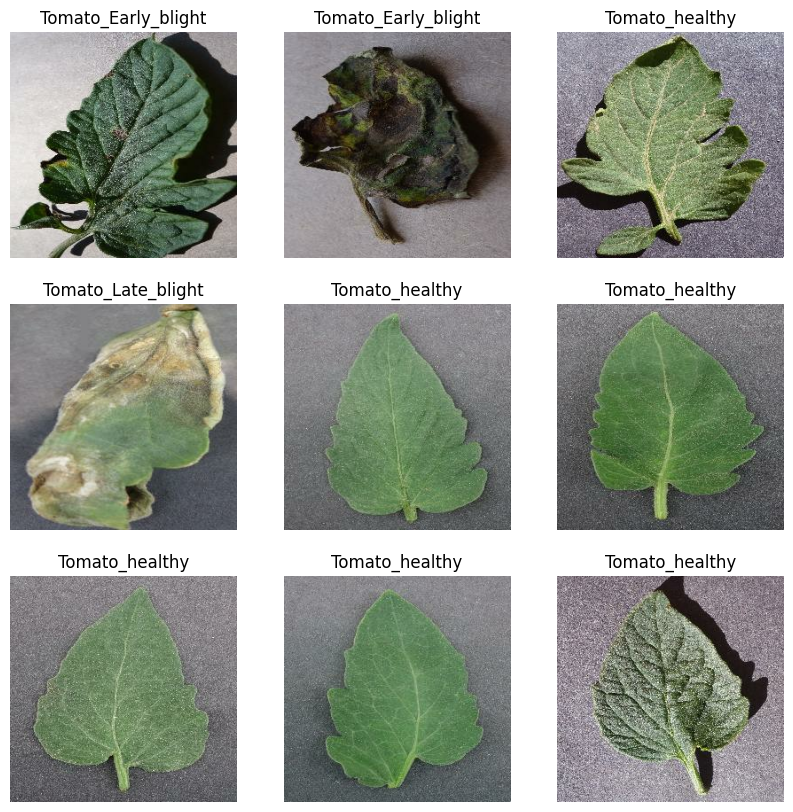

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Preprocessing

### Train-Test Split

In [11]:
train_size = 0.8
train_len = int(round(len(dataset)*train_size,0))
print(train_len)

113


In [12]:
train_ds = dataset.take(train_len)
len(train_ds)

113

In [13]:
val_size = 0.1
val_len = int(round(len(dataset)*val_size,0))
print(val_len)

14


In [14]:
test_size = 0.1
test_len = int(round(len(dataset)*test_size,0))
print(test_len)

14


In [15]:
test_val_ds = dataset.skip(train_len)
len(test_val_ds)

28

In [16]:
val_ds = test_val_ds.take(val_len)
len(val_ds)

14

In [17]:
test_ds = test_val_ds.skip(val_len)
len(test_ds)

14

### Cache, Shuffle, Prefetch

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Modeling

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(.5, .2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
#model.summary()

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
113/113 [==============================] - 918s 5s/step - loss: 0.8710 - accuracy: 0.5559 - val_loss: 0.9907 - val_accuracy: 0.6272
Epoch 2/20
113/113 [==============================] - 526s 5s/step - loss: 0.4387 - accuracy: 0.8180 - val_loss: 1.1124 - val_accuracy: 0.6406
Epoch 3/20
113/113 [==============================] - 522s 5s/step - loss: 0.3776 - accuracy: 0.8429 - val_loss: 0.5063 - val_accuracy: 0.7924
Epoch 4/20
113/113 [==============================] - 513s 5s/step - loss: 0.3334 - accuracy: 0.8620 - val_loss: 0.6583 - val_accuracy: 0.7746
Epoch 5/20
113/113 [==============================] - 517s 5s/step - loss: 0.3019 - accuracy: 0.8689 - val_loss: 0.4483 - val_accuracy: 0.7812
Epoch 6/20
113/113 [==============================] - 546s 5s/step - loss: 0.3270 - accuracy: 0.8648 - val_loss: 0.4283 - val_accuracy: 0.8036
Epoch 7/20
113/113 [==============================] - 512s 5s/step - loss: 0.2620 - accuracy: 0.8927 - val_loss: 0.4135 - val_accuracy: 0.8259

In [26]:
model.save('TomatoeModel1.keras')

In [27]:
model.save('TomatoesModel1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [33]:
import torch

In [37]:
from keras.models import load_model

model_save_name = 'TomatoesModel1.keras'
path = f"/content/gdrive/My Drive/TomatoesModel1.keras"
model.save(path)